In [67]:
import os
import random
from time import time

import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import skimage
from skimage import io as skimg_io
from skimage.transform import resize

import sklearn
from sklearn import  linear_model, svm, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
%matplotlib inline

In [13]:
IMAGE_W = 64
IMAGE_H = 64

In [4]:
images_dir = '../input/train'
train_images_description_file_path = '../input/train.csv'

In [5]:
train_images_description_df = pd.read_csv(train_images_description_file_path)
print(train_images_description_df.head())
print(train_images_description_df.shape)

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale
(25361, 2)


In [6]:
train_images_description_df_two_classes = train_images_description_df.copy()

In [8]:
train_images_description_df_two_classes.loc[train_images_description_df_two_classes['Id'] != 'new_whale', 'Id'] = 'not_new_whale'

In [9]:
train_images_description_df_two_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
Image    25361 non-null object
Id       25361 non-null object
dtypes: object(2)
memory usage: 396.3+ KB


In [10]:
train_images_description_df_two_classes['NumId'] = 0

In [11]:
train_images_description_df_two_classes.loc[train_images_description_df_two_classes['Id'] != 'new_whale', 'NumId'] = 1

In [12]:
train_images_description_df_two_classes.head()

,Image,Id,NumId
0,0000e88ab.jpg,not_new_whale,1
1,0001f9222.jpg,not_new_whale,1
2,00029d126.jpg,not_new_whale,1
3,00050a15a.jpg,new_whale,0
4,0005c1ef8.jpg,new_whale,0


In [19]:
for row in train_images_description_df_two_classes.head().iterrows():
    print(type(row[1]))
    print(len(row[1]))
    print(row[1])

<class 'pandas.core.series.Series'>
3
Image    0000e88ab.jpg
Id       not_new_whale
NumId                1
Name: 0, dtype: object
<class 'pandas.core.series.Series'>
3
Image    0001f9222.jpg
Id       not_new_whale
NumId                1
Name: 1, dtype: object
<class 'pandas.core.series.Series'>
3
Image    00029d126.jpg
Id       not_new_whale
NumId                1
Name: 2, dtype: object
<class 'pandas.core.series.Series'>
3
Image    00050a15a.jpg
Id           new_whale
NumId                0
Name: 3, dtype: object
<class 'pandas.core.series.Series'>
3
Image    0005c1ef8.jpg
Id           new_whale
NumId                0
Name: 4, dtype: object


In [25]:
images = [
    (row[1]['Image'], row[1]['NumId'], resize(
        skimg_io.imread(
                pathlib.Path(images_dir, row[1]['Image']).as_posix(),
                as_grey=True
            ),
            (IMAGE_W, IMAGE_H)
        )
    ) for row in train_images_description_df_two_classes.iterrows()]

In [24]:
#del images

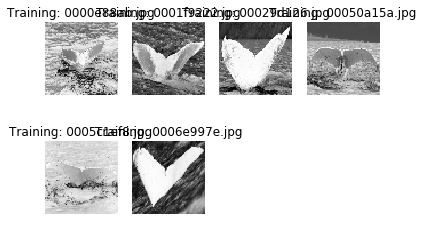

In [28]:
for index, image_item in enumerate(images[:6]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image_item[2], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %s' % image_item[0])

In [29]:
image_item = images[0]

In [30]:
image_0 = image_item[2]

In [31]:
type(image_0)

numpy.ndarray

In [32]:
image_0.flatten?

In [33]:
X = np.array([image_item[2].flatten() for image_item in images])

In [34]:
X.shape

(25361, 4096)

In [35]:
y = np.array([image_item[1] for image_item in images])

In [36]:
y[:5]

array([1, 1, 1, 0, 0])

In [37]:
X.shape

(25361, 4096)

In [42]:
train_size = int(X.shape[0] / 5 * 4)

In [43]:
train_size

20288

In [44]:
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [46]:
svm_classifier = svm.SVC(gamma=0.001)

In [47]:
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
y_pred = svm_classifier.predict(X_test)

In [49]:
accuracy = metrics.accuracy_score(y_pred, y_test)

In [50]:
print(accuracy)

0.6607530061107826


In [51]:
logr_classifier = linear_model.LogisticRegression(n_jobs=8)

In [52]:
logr_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=8,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
y_logr_predict = logr_classifier.predict(X_test)

In [54]:
logr_accuracy = metrics.accuracy_score(y_logr_predict, y_test)

In [55]:
print(logr_accuracy)

0.6041789867928248


In [71]:
#t0 = time()
'''
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear', 'rbf']
             }
'''
param_grid = {'C': [1e3, 5e3],
              'gamma': [0.0005, 0.001],
              'kernel': ['linear', 'rbf']
             }

In [63]:
'''
svm_multiprocess_cv_classifier = GridSearchCV(
    cross_val_score(
        svm.SVC(),
        X,
        y,
        cv=5,
        n_jobs=8
    ),
    param_grid,
    cv=5
)
'''

In [65]:
#svm_m = clf.fit(X_train_pca, y_train)
#print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(svm_multiprocess_cv_classifier.estimator)

Best estimator found by grid search:
[0.64833432 0.64656022 0.64511041 0.6466877  0.64405443]


In [75]:
svm_grid_search_cv_classifier = GridSearchCV(svm.SVC(), param_grid, cv=3, n_jobs=6)

In [ ]:
t0 = time()
%timeit
svm_grid_search_cv_classifier = svm_grid_search_cv_classifier.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(svm_grid_search_cv_classifier.best_estimator_)